<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

# Imports and settings

In [1]:
!pip install -U torchinfo

In [2]:
import collections
import itertools
import joblib
import os
import random
import shutil
import sys
import time
import zipfile

import IPython

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm.notebook as tqdm
%matplotlib inline

import skimage
import skimage.io
import skimage.transform

import sklearn
import sklearn.model_selection
import sklearn.manifold
import sklearn.metrics
import sklearn.neighbors
import sklearn.cluster
import sklearn.preprocessing

import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import torchvision.transforms as tt
import torchvision.models as vision_models
import torchvision.utils as vision_utils
import torchvision.datasets as vision_datasets
import torchinfo

In [3]:
sns.set(style='darkgrid', font_scale=1.2)
plt.rcParams["figure.figsize"] = (20, 20)

# Setting random seeds for reproducibility

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

# Determining available device

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Setting globals

In [6]:
BATCH_SIZE = 512
LATENT_SPACE_SIZE = 128
IMAGE_SIZE = 64
NORMALIZATION_PARAMS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
SAMPLE_DIR = "/content/sample_dir" if "google.colab" in str(get_ipython()) else "sample_dir"
FIXED_LATENT = torch.normal(0, 1, size=(64, LATENT_SPACE_SIZE, 1, 1), device=DEVICE)

In [7]:
try:
    os.mkdir(SAMPLE_DIR)
except FileExistsError:
    pass # already exists

# Helper functions and classes

In [8]:
class FacesDataset(data_utils.Dataset):
    def __init__(self, img_dir, transform=None, in_memory=False):
        self.img_dir = os.path.abspath(img_dir)
        self.img_names = sorted(list(os.listdir(self.img_dir)))
        self.transform = transform
        self.in_memory = in_memory
        self.data = None
        if self.in_memory:
            self.data = []
            for i in tqdm.tqdm(self.img_names, desc="Reading images", unit="images", unit_scale=False):
                image = skimage.img_as_float32(skimage.io.imread(os.path.join(img_dir, i)))
                self.data.append(image)
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        if self.in_memory:
            image = self.data[idx]
        else:
            img_path = os.path.join(self.img_dir, self.img_names[idx])
            image = skimage.img_as_float32(skimage.io.imread(img_path))
        if self.transform:
            image = self.transform(image)
        return image

In [9]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.noise = torch.tensor(0).to(DEVICE)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach()
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x

In [10]:
def noisy_targets(targets, p=0.05, mode="real"):
    targets = targets.squeeze()
    if not mode in ("real", "fake"):
        raise ValueError("Unrecognized noisy targets mode")
    n_select = int(p * int(targets.size(0)))
    idx = torch.LongTensor(np.random.choice([i for i in range(int(targets.size(0)))], size=n_select)).to(targets.device)
    if mode == "real":
        values = torch.empty((n_select,)).uniform_(0., 0.3).to(targets.device)
        targets.index_copy_(0, idx, values)
    else:
        values = torch.empty((n_select,)).uniform_(0.7, 1.2).to(targets.device)
        targets.index_copy_(0, idx, values)
    idx, values = idx.cpu(), values.cpu()
    del idx, values
    return targets.unsqueeze(-1)

In [11]:
def soft_targets(targets, mode="real"):
    if mode not in ("real", "fake"):
        raise ValueError("Unrecognized soft targets operation mode")
    if mode == "real":
        return torch.empty_like(targets).uniform_(0.7, 1.2)
    else:
        return torch.empty_like(targets).uniform_(0., 0.3)

In [12]:
def fit_epoch_discriminator(real, discriminator, generator, optimizer, criterion, batch_size, latent_size, epoch, epochs_count):
    try:
        optimizer.zero_grad()

        real_preds = discriminator(real)
        # see https://github.com/soumith/ganhacks №6
        real_targets = noisy_targets(soft_targets(torch.ones(real.size(0), 1, device=DEVICE)))
        real_loss = criterion(real_preds, real_targets)
        real_loss.backward()
        real_score = torch.mean(real_preds).item()

        latent = torch.normal(0, 1, size=(batch_size, latent_size, 1, 1)).to(DEVICE)
        fake = generator(latent)
        fake_preds = discriminator(fake)
        # see https://github.com/soumith/ganhacks №6
        fake_targets = noisy_targets(soft_targets(torch.zeros(fake.size(0), 1, device=DEVICE), mode="fake"), mode="fake")
        fake_loss = criterion(fake_preds, fake_targets)
        fake_loss.backward()
        fake_score = torch.mean(fake_preds).item()

        loss_discriminator = 0.5 * (real_loss + fake_loss)
        optimizer.step()
    finally:
        real_targets, real_preds, fake_targets, fake_preds = \
        real_targets.cpu(), real_preds.cpu(), fake_targets.cpu(), fake_preds.cpu()
        del real_targets, real_preds, fake_targets, fake_preds
        torch.cuda.empty_cache()
    return loss_discriminator, real_score, fake_score

def fit_epoch_generator(generator, discriminator, optimizer, criterion, batch_size, latent_size):
    try:
        optimizer.zero_grad()
        latent = torch.normal(0, 1, size=(batch_size, latent_size, 1, 1)).to(DEVICE)
        fake = generator(latent)
        preds = discriminator(fake)
        targets = soft_targets(torch.ones(batch_size, 1, device=DEVICE)) # see https://github.com/soumith/ganhacks №2 and №6
        loss_generator = criterion(preds, targets)
        loss_generator.backward()
        optimizer.step()
    finally:
        latent, preds, targets = latent.cpu(), preds.cpu(), targets.cpu()
        del latent, preds, targets
        torch.cuda.empty_cache()
    return loss_generator

In [13]:
def fit_epoch(data_train, models, optimizers, criteria, batch_size, latent_size, epoch, epochs_count):
    models["generator"].train()
    models["discriminator"].train()
    losses_discriminator = []
    losses_generator = []
    real_scores = []
    fake_scores = []
    for real_images in tqdm.tqdm(data_train, desc=f"Fitting epoch {epoch + 1}", unit="batch", unit_scale=False):
        try:
            real_images = real_images.to(DEVICE)

            loss_discriminator, real_score, fake_score = fit_epoch_discriminator(real_images, models["discriminator"], models["generator"], \
                                                                                 optimizers["discriminator"], criteria["discriminator"], \
                                                                                 batch_size, latent_size, \
                                                                                 epoch, epochs_count)
            losses_discriminator.append(loss_discriminator.item())
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            loss_generator = fit_epoch_generator(models["generator"], models["discriminator"], \
                                                 optimizers["generator"], criteria["generator"], \
                                                 batch_size, latent_size)
            losses_generator.append(loss_generator.item())
        finally:
            real_images = real_images.to("cpu")
            del real_images
            torch.cuda.empty_cache()
    return np.mean(losses_generator), np.mean(losses_discriminator), np.mean(real_scores), np.mean(fake_scores)
  
def train_model(data_train, models, optimizers, criteria, epochs, batch_size, latent_size, schedulers=None, start_epoch=0, sample_save_cooldown=25):
    history = []

    start_time = time.time()

    with tqdm.tqdm(desc="Epoch", total=epochs) as pbar_outer:
        for epoch in range(start_epoch, epochs):
            try:
                gen_loss, disc_loss, real_score, fake_score = fit_epoch(data_train, models, optimizers, criteria, batch_size, latent_size, epoch, epochs)
                IPython.display.clear_output(wait=True)

                if schedulers is not None:
                    if schedulers["generator"] is not None:
                        schedulers["generator"].step(gen_loss)
                    if schedulers["discriminator"] is not None:
                        schedulers["discriminator"].step(disc_loss)

                history.append((gen_loss, disc_loss, real_score, fake_score))

                show_generated_train(generator, epoch, history[-1], latent_size)

                pbar_outer.update(1)
                pbar_outer.refresh()

                if (epoch + 1) % sample_save_cooldown == 0:
                    save_samples(generator, epoch)
            except KeyboardInterrupt as stop:
                tqdm.tqdm.write(f"Training interrupted at epoch {epoch + 1}. Returning history")
                return history
        
    end_time = time.time()
    train_time = end_time - start_time
    tqdm.tqdm.write(f"Overall training time: {train_time: 0.1f} seconds")

    return history

In [14]:
def show_generated_train(generator, epoch, epoch_stats, latent_size, sample_size=16):
    log_template = "Generated images on epoch {ep: 03d}.\n\
    Generator loss: {g_loss: 0.4f}, discriminator loss: {d_loss: 0.4f}\n\
    Real score: {r_score: 0.4f}, fake score: {f_score: 0.4f}"
    try:
        nrow = int(np.ceil(np.sqrt(sample_size)))
        latent = torch.normal(0, 1, size=(sample_size, latent_size, 1, 1), device=DEVICE)
        output = generator(latent)
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(vision_utils.make_grid(denormalize_images(output.detach().cpu()), nrow=nrow).permute(1, 2, 0).numpy())
        plt.suptitle(log_template.format(ep=epoch + 1, \
                                        g_loss=epoch_stats[0], d_loss=epoch_stats[1], \
                                        r_score=epoch_stats[2], f_score=epoch_stats[3]))
        plt.show()
    finally:
        latent, output = latent.to("cpu"), output.to("cpu")
        del latent, output
        torch.cuda.empty_cache()

def denormalize_images(images):
    return images * NORMALIZATION_PARAMS[1][0] + NORMALIZATION_PARAMS[0][0]

def save_samples(generator, epoch, sample_size=16):
    try:
        nrow = int(np.ceil(np.sqrt(sample_size)))
        with torch.no_grad():
            fake_images = generator(FIXED_LATENT)
        fake_fname = f"generated-images-{epoch + 1}.png"
        vision_utils.save_image(denormalize_images(fake_images)[:sample_size], os.path.join(SAMPLE_DIR, fake_fname), nrow=nrow)
        print(f"Saving generated images to {fake_fname}")
    finally:
        fake_images = fake_images.cpu()
        del fake_images
        torch.cuda.empty_cache()

def show_images(images, sample_size, figsize=(15, 15)):
    nrow = int(np.ceil(np.sqrt(sample_size)))
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(vision_utils.make_grid(denormalize_images(images[:sample_size]), nrow=nrow).permute(1, 2, 0).numpy())

In [15]:
def plot_losses(history):
    gen_loss, disc_loss, _, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(gen_loss, "-", label="Generator loss")
    plt.plot(disc_loss, "-", label="Discriminator loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.title("Generator and discriminator losses during training")
    plt.show()

def plot_scores(history):
    _, _, real_score, fake_score = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(real_score, "-", label="Real images discriminator score")
    plt.plot(fake_score, "-", label="Fake images discriminator score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Discriminator scores for real and fake images during training")
    plt.show()

# Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [16]:
def prepare_dataset(filename="faces_dataset_small.zip", transform=None, in_memory=False):
    """
    Fetches the data from Google Drive (or loads from a local folder/archive) and returns a custom Dataset with specified transforms
    :param url: Google Drive file url
    :param path: Path where to download the dataset archive
    :returns: FacesDataset object
    """
    img_folder, _ = os.path.splitext(filename)
    if "google.colab" in str(IPython.get_ipython()):
        from google.colab import drive
        drive.mount("/content/drive")
        shutil.copy(f"/content/drive/MyDrive/{filename}", f"/content/{filename}")
        with zipfile.ZipFile(f"/content/{filename}", "r") as archive:
            for member in tqdm.tqdm(archive.namelist(), desc="Extracting files", unit="files", unit_scale=False):
              archive.extract(member, "/content")
    else:
        if os.path.isfile(filename):
            shutil.rmtree(img_folder, ignore_errors=True) # clear out old data
            with zipfile.ZipFile(filename, "r") as archive:
                for member in tqdm.tqdm(archive.namelist(), desc="Extracting files", unit="files", unit_scale=False):
                    archive.extract(member, os.getcwd())
    dataset = FacesDataset(img_folder, transform=transform, in_memory=in_memory)
    return dataset

In [17]:
def get_dataloader(batch_size, **kwargs):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :param **kwargs: arguments to be passed to download_and_prepare_dataset
    :returns: DataLoader object 
    """
    dataset = prepare_dataset(**kwargs)
    loader = data_utils.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True, drop_last=True)
    return loader

In [18]:
loader = get_dataloader(BATCH_SIZE, 
                        transform=tt.Compose([
                                            tt.ToTensor(),
                                            tt.CenterCrop(IMAGE_SIZE),
                                            tt.Normalize(*NORMALIZATION_PARAMS)
                                            ]),
                        in_memory=True
                        )

Mounted at /content/drive


Extracting files:   0%|          | 0/3143 [00:00<?, ?files/s]

Reading images:   0%|          | 0/3143 [00:00<?, ?images/s]

In [19]:
next(iter(loader)).shape

torch.Size([512, 3, 64, 64])

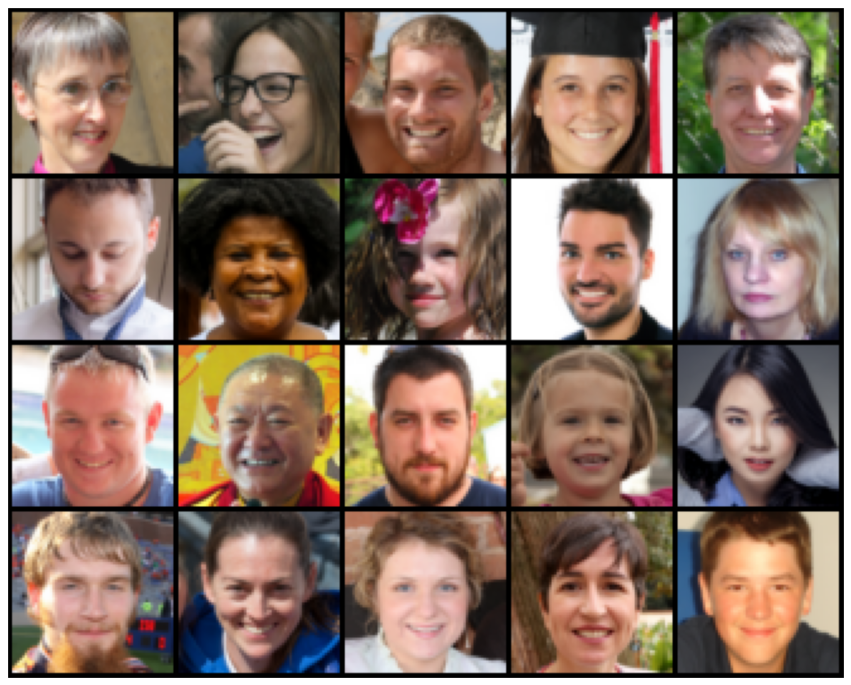

In [20]:
show_images(next(iter(loader)), 20)

# Часть 2. Построение и обучение модели (2 балла)

## Defining architectures

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [21]:
def weights_init(module):
    """
    The DCGAN paper (https://arxiv.org/abs/1511.06434v2) defines layer initialization as normal distribution with mean=0, stddev=0.02
    This function reinitializes all convolutional and batchnorm layers using these parameters.
    :param module: layer (of type nn.Module)
    """
    classname = module.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(LATENT_SPACE_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())
    
    def forward(self, z):
        return self.layers(z)

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.layers(x)

In [24]:
generator = Generator().to(DEVICE)
#generator.apply(weights_init)

In [25]:
torchinfo.summary(generator, (BATCH_SIZE, LATENT_SPACE_SIZE, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [512, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [512, 512, 4, 4]          1,048,576
│    └─BatchNorm2d: 2-2                  [512, 512, 4, 4]          1,024
│    └─ReLU: 2-3                         [512, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [512, 256, 8, 8]          2,097,152
│    └─BatchNorm2d: 2-5                  [512, 256, 8, 8]          512
│    └─ReLU: 2-6                         [512, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [512, 128, 16, 16]        524,288
│    └─BatchNorm2d: 2-8                  [512, 128, 16, 16]        256
│    └─ReLU: 2-9                         [512, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [512, 64, 32, 32]         131,072
│    └─BatchNorm2d: 2-11                 [512, 64, 32, 3

In [26]:
discriminator = Discriminator().to(DEVICE)
#discriminator.apply(weights_init)

In [27]:
torchinfo.summary(discriminator, (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [512, 1]                  --
│    └─Conv2d: 2-1                       [512, 64, 32, 32]         3,072
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         128
│    └─LeakyReLU: 2-3                    [512, 64, 32, 32]         --
│    └─Conv2d: 2-4                       [512, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-5                  [512, 128, 16, 16]        256
│    └─LeakyReLU: 2-6                    [512, 128, 16, 16]        --
│    └─Conv2d: 2-7                       [512, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-8                  [512, 256, 8, 8]          512
│    └─LeakyReLU: 2-9                    [512, 256, 8, 8]          --
│    └─Conv2d: 2-10                      [512, 512, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-11                 [512, 512, 4, 4]     

In [28]:
!nvidia-smi

Wed Jan 12 15:40:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    88W / 149W |   2510MiB / 11441MiB |     54%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Training DCGAN

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса
  
  Замечание: при обучении дискриминатора используется зашумление и сглаживание меток.
2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет

  Замечание: при обучении генератора используется сглаживание меток

В качестве функции потерь берем бинарную кросс-энтропию.

In [29]:
models = {
    "discriminator": discriminator,
    "generator": generator
}

criteria = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizers = {
    "discriminator": torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
}

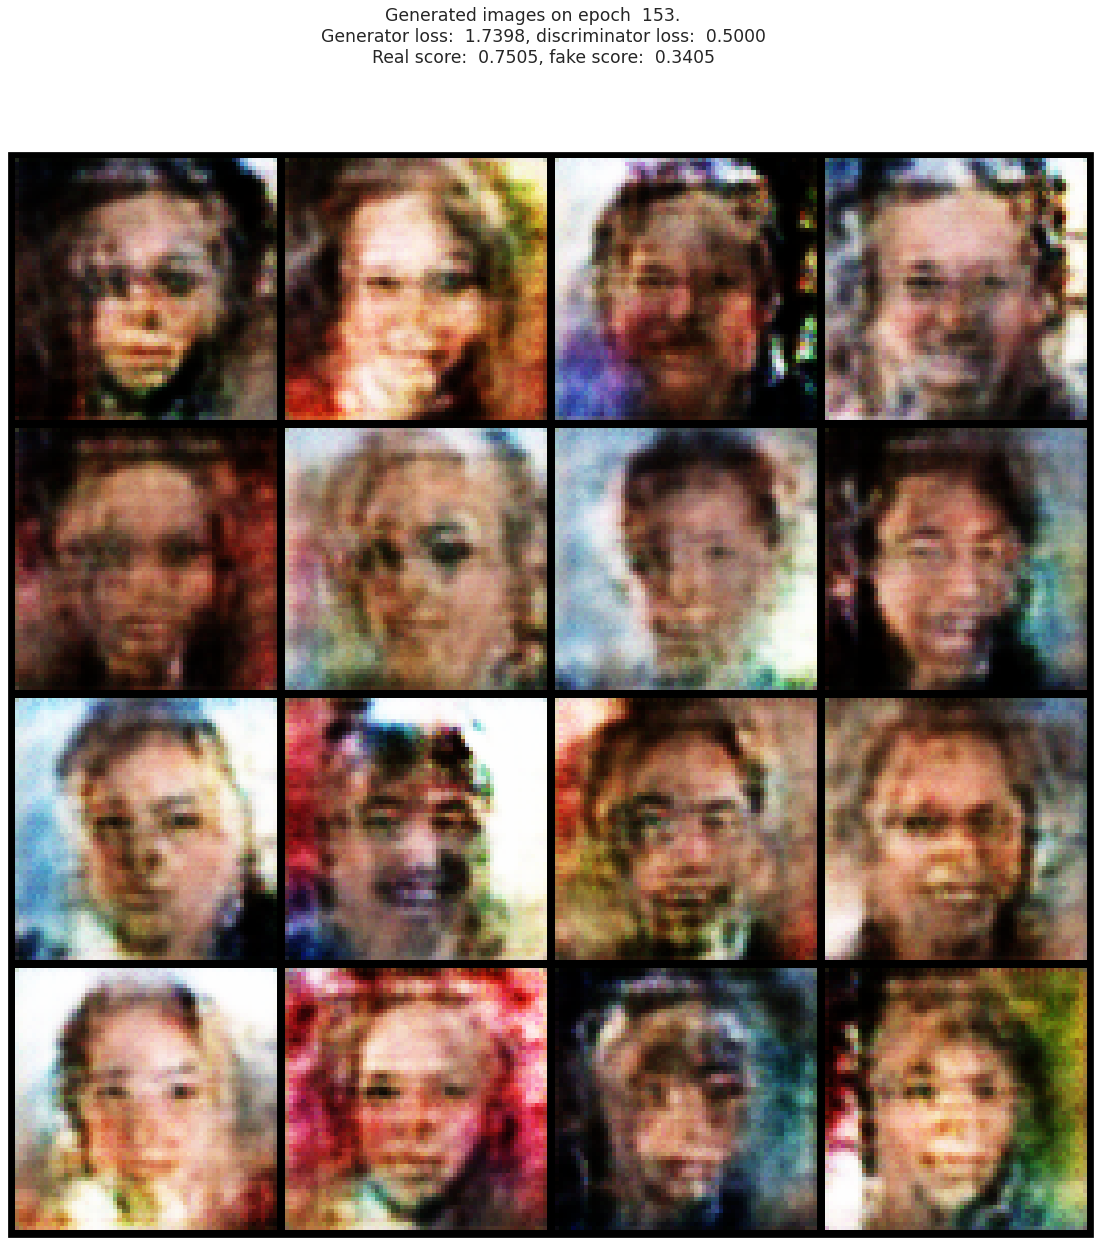

Fitting epoch 154:   0%|          | 0/6 [00:00<?, ?batch/s]

In [ ]:
max_epochs = 300
history_gan = train_model(loader, models, optimizers, criteria, max_epochs, BATCH_SIZE, LATENT_SPACE_SIZE)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
plot_losses(history_gan)

In [ ]:
plot_scores(history_gan)

# Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
fake_images = models["generator"](FIXED_LATENT).detach().cpu()
show_images(fake_images, 12)

Как вам качество получившихся изображений?

Похоже на лица, но довольно мутно + присутствуют шумы.

Возможные методы исправления:
* Изменение гиперпараметров оптимизаторов или самих оптимизаторов, например, использовать SGD для дискриминатора и Adam для генератора, или Adam для обеих сетей. Также можно настраивать lr и $\beta_1$/$\beta_2$ (в случае Adam).
* Изменение лосса с MSE на бинарную кросс-энтропию и обратно.
* Изменение количества эпох (возможно, модель недообучена).
* Сохранение чекпоинтов генератора и дискриминатора на некоторых эпохах и периодическая замена весов на веса из чекпоинтов (чтобы та сеть, которая не смогла дообучиться, дообучилась бы).
* Добавление шума в генератор (поэкспериментировать с количеством слоёв, входы на которые зашумляются).
* Дропауты в генераторе.
* [Wasserstein GANs](https://arxiv.org/abs/1701.07875) или их модификация (например, [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf)).
* [Energy-based GANs](https://arxiv.org/abs/1609.03126).

# Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
def generate_fakes(loader, generator, batch_size, latent_size):
    fakes = []
    for real in tqdm.tqdm(loader, desc="Generating fakes"):
        try:
            latent = torch.normal(0, 1, size=(BATCH_SIZE, LATENT_SPACE_SIZE, 1, 1), device=DEVICE)
            with torch.no_grad():
                outputs = generator(latent).detach().cpu()
            fakes.append(outputs)
        finally:
            latent = latent.cpu()
            del latent
            torch.cuda.empty_cache()
    return torch.flatten(torch.stack(fakes), end_dim=1)

In [ ]:
real = torch.flatten(torch.stack([i for i in tqdm.tqdm(loader, desc="Loading real images")]), end_dim=1)
fakes = generate_fakes(loader, models["generator"], BATCH_SIZE, LATENT_SPACE_SIZE)

In [ ]:
X = torch.flatten(torch.stack([real, fakes]), end_dim=1).numpy()
y = torch.flatten(torch.stack([torch.Tensor([1 for i in real]), torch.Tensor([0 for i in fakes])]), end_dim=1).numpy()

In [ ]:
num_images = BATCH_SIZE * len(loader)
X = X.reshape(2*num_images, -1)

In [ ]:
def fit_1nn_per_image(X, y, train_idx, test_idx):
    one_nn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    one_nn.fit(X_train, y_train.ravel())
    y_pred = one_nn.predict(X_test)
    return sklearn.metrics.accuracy_score(y_test, y_pred)

In [ ]:
loo = sklearn.model_selection.LeaveOneOut()

accuracies = joblib.Parallel(n_jobs=-1)(joblib.delayed(fit_1nn_per_image)(X, y, train_idx, test_idx) for train_idx, test_idx in tqdm.tqdm(loo.split(X), total=loo.get_n_splits(X), desc="Making 1NN LOO accuracies"))

print(f"Mean 1NN accuracy: {np.mean(accuracies)}")

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
images_compressed = sklearn.manifold.TSNE(n_components=2, init="random", learning_rate=200.0, verbose=1).fit_transform(X)
print("[t-SNE] Done.")

In [ ]:
def plot_latent_compressed(data, targets):
    num_classes=2
    plt.figure(figsize=(20, 10))
    d = {i:[] for i in range(num_classes)}
    
    for j in range(num_classes):
        if j in targets:
            mask = (targets == j)
            d[j].append(data[mask])

    colors = list(matplotlib.colors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        label = "real"if i else "fake"
        plt.scatter(d[i][:, 0], d[i][:, 1], c=colors[i][1], label=label, alpha=0.5)
        
    kmeans = sklearn.cluster.KMeans(n_clusters=num_classes)
    X = np.concatenate(list(d.values()))
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    for i, center in enumerate(centroids):
        plt.text(center[0], center[1], str(i), fontdict={"size": 20, "weight": "bold"})
        
    plt.title("Real/fake pictures distribution")
    plt.colorbar()
    plt.legend()
    plt.plot();

In [ ]:
plot_latent_compressed(X, y)

Прокомментируйте получившийся результат:

# Clear unused models

In [ ]:
generator, discriminator = generator.cpu(), discriminator.cpu()
del generator, discriminator
torch.cuda.empty_cache()